## <ins style = "color : orange">Report by KHOUTAIBI Iliass and BARAKA Rayane: </ins>

In this practical work, We will implement the PSOLA method for the analysis/synthesis of speech signals. We will then apply these implementations of the classic: <strong> A E I O U </strong> sound.

Before starting our report, we will start by importing some useful modules and implementing some helper functions.

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
import scipy as sp

### <ins style = " color : green"> Some helper functions: </ins>

We define a $\texttt{plot\_sound}$ function, which plots a given sound signal.

We also define a $\texttt{nextpow2}$ function, which computes the next power of two of a given float $ x $.

Finally, we define a $\texttt{period}$ function which, given a signal $ x $ and a sampling rate $ F_s $, returns:


\begin{aligned}
    P_a & : \text{the pitch of the signal} \\
    \text{voiced} & : \text{a boolean indicating whether the sound is voiced or not}
\end{aligned}



In [65]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

In order to play sound files and the sampling rate of the said file, we shall use some imported helper functions, which take the path of the file. Let us for instance, play the $\text{aeiou.wav}$ wavefile.

In [66]:
# Reading the soundfile
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

# Getting the signal and sampling rate
x, Fs= sf.read(file_path)

# Displaying the audio file to play
IPython.display.Audio(file_path)

Let's test plotting the soundfile, we first need to get the timestep of the signal, which can be easily calculated using the sampling rate.

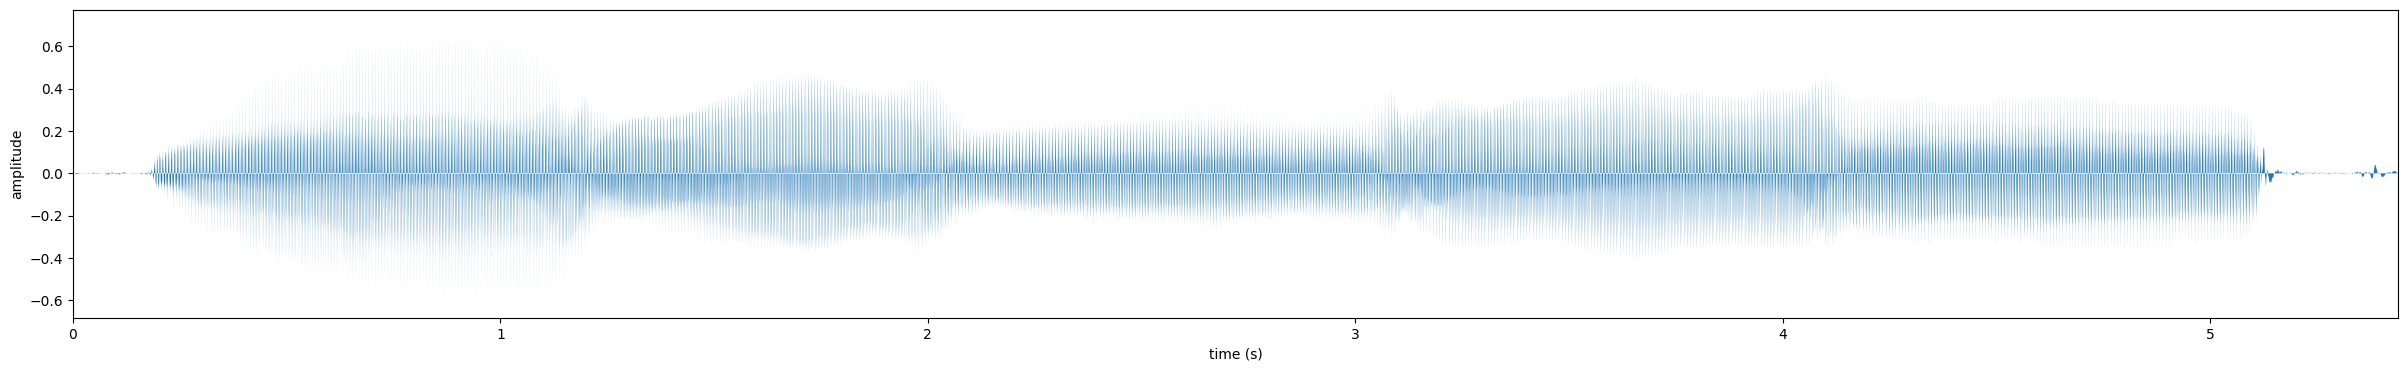

In [67]:
# Getting the Timestep using the sampling rate
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

# Plotting the soundfile 
plot_sound(x, times)

Writing a sound file is as easy as reading it, we just need to make sure we use the correct sampling rate otherwise we get some erronuous results!

In [68]:
# Writing into a file
sf.write('new_aeiou.wav',x, samplerate=Fs)

### <ins style = "color : pink"> Analyzing the pitch marks of a signal</ins>

Firstly, we will program the following function:

$$ \texttt{function A = AnalysisPitchMarks(s, Fs)} $$ 

This function extracts the analysis marks. The arguments $s$ and $F_s$ are respectively the signal to be analyzed and the sampling frequency. The returned matrix $A$ will contain the times and pitches corresponding to each analysis mark. More precisely, $A$ will be a matrix with three rows such that:

$$
\begin{aligned}
A(1, n) &= t_a(n) \quad \text{Time of the } n^\text{th} \text{ analysis mark (in samples)} \\
A(2, n) &= \text{voiced}(n) \quad \text{Boolean indicating whether the signal is voiced near this mark} \\
A(3, n) &= P_a(n) \quad \text{Pitch corresponding to the same mark (in samples)}
\end{aligned}
$$

To determine the analysis marks, we do not attempt to align $t_a(n)$ with the beginning of a glottal pulse. To compute $P_a(n)$ and $t_a(n)$, we proceed recursively for $n \geq 1$:

- Extract a sequence $x$ starting at time $t_a(n - 1)$, with duration $2.5 \cdot P_a(n - 1)$  
- Compute $P_a(n)$ and $\text{voiced}(n)$ using the $\texttt{period}$ function  
- Compute the next time mark as:

$$
t_a(n) = t_a(n - 1) + P_a(n)
$$


In [69]:
def AnalysisPitchMark(signal, Fs):
    """
        Analysis Pitch function which returns the analysis mark,
        The pitch of the signal and wether it is voiced or not
        --------------------------------------------------
        returns :
            t_a : Analysis mark
            voiced : boolean determining if the signal is voiced or not
            Pa : Pitch of the signal
    
    """

    # Init the A matrix
    n = len(signal)
    A = np.zeros((3, n))
    index = 1 # index to stop from getting out of range
    Pa = 0.1 * Fs
    ta = 0
    A[0, 0] = ta
    A[2, 0] = Pa
    
    # Adding a condition in order not to go out of range
    while int(ta + 2.5 * Pa) <= n:
        
        # Applying the recursion 
        ta = A[0, index - 1]
        Pa = A[2, index - 1]

        start = int(ta)
        end = int(ta + 2.5 * Pa)

        signal_segment = signal[start : end]

        # Determining [Pa, voiced] of the subsignal
        Pa, voiced = period(signal_segment, Fs)
        A[1, index] = voiced
        A[2, index] = Pa
        ta = ta + Pa
        A[0, index] = ta

        index += 1

    # Slicing the array to get the useful part
    return A[:, :index]

Executing the previous function for the $\text{aeiou.wav}$ soundfile gives us the following Matrix 

In [70]:
A = AnalysisPitchMark(x, Fs)
print(f"The A matrix for the aeiou sound file is:\n {A/Fs}")

The A matrix for the aeiou sound file is:
 [[0.00000000e+00 7.07482993e-03 1.70521542e-02 ... 5.39419501e+00
  5.40417234e+00 5.41414966e+00]
 [0.00000000e+00 9.07029478e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e-01 7.07482993e-03 9.97732426e-03 ... 9.97732426e-03
  9.97732426e-03 9.97732426e-03]]


To perform the synthesis of the signal, we must start by defining the <span style = "color : orange" >synthesis marks </span>. They are stored in a matrix $B$ composed of two rows, such that:

- $B(1, k) = t_s(k)$ is the time corresponding to the $k^\text{th}$ synthesis mark
- $B(2, k) = n(k)$ is the index of the **analysis mark** associated with this same synthesis mark

To begin, we start by performing a synthesis without any modification by simply setting:

- $B(1, :) = A(1, :)$
- $B(2, :) = [1, 2, 3, \ldots]$

In [71]:
# Init the B matrix
B = np.zeros((2, A.shape[1]))     
B[0, :] = A[0, :]
B[1, :] = np.arange(1, A.shape[1] + 1)

### <ins style = "color : orange">Synthesising the signal</ins>

We will now program the following function:

$$\texttt{function y = Synthesis(s, Fs, A, B)}$$

This function computes the synthesis signal $y$ from:

- the original signal $s$,
- the sampling frequency $F_s$,
- the analysis marks stored in matrix $A$,
- and the synthesis marks stored in matrix $B$.

The synthesis is performed recursively for $k \geq 1$. The output vector $y$ is initialized as a zero vector of dimension:

$$
t_s(k_{\text{end}}) + P_a(n(k_{\text{end}}))
$$

For each synthesis mark:

- Extract a segment $x$ centered at $t_a(n(k))$ and of length $2P_a(n(k)) + 1$
- Apply a Hann window to $x$ (use the MATLAB function hann or the Python function scipy.signal.hanning)
- Perform overlap-add of the windowed sequence into $y$ at the interval:

$$
y[t_s(k) - P_a(n(k)) :\ t_s(k) + P_a(n(k))]
$$

In [ ]:
def Synthesis(s, Fs, A, B):
    """
        Synthesising the signal using the previously defined algotihm
        -------------------------------------------------------------------
        returns :
            y : New synthesised signal
    """
    
    nk_end = int(B[1, -1])
    y = np.zeros(int(B[0, -1] + A[2, nk_end - 1]))
    
    for k in range(B.shape[1]):

        n_k = int(B[1, k])

        if n_k >= A.shape[1]:  
            continue
        
        ts = int(B[0, k])
        ta = int(A[0, n_k])
        Pa = int(A[2, n_k])

        # Windowing the signal
        x = s[ta - int(Pa+1/2) : ta + int(Pa+1/2)]
        x = x * np.hanning(len(x))
        
        # Condition if index out of range
        if len(y[ts - Pa : ts + Pa]) != len(x) :
            continue
        
        # Adding x to the synthesised signal
        y[ts - Pa : ts + Pa] += x
    
    return y

To test the correctness of our method, we will rebuild the orginal $\text{aeiou}$ signal.

In [73]:
# Rebuild aeiou signal using the previous function
y = Synthesis(x, Fs, A, B)
# Writing into a file
sf.write('synthesis.wav',y , samplerate=Fs)

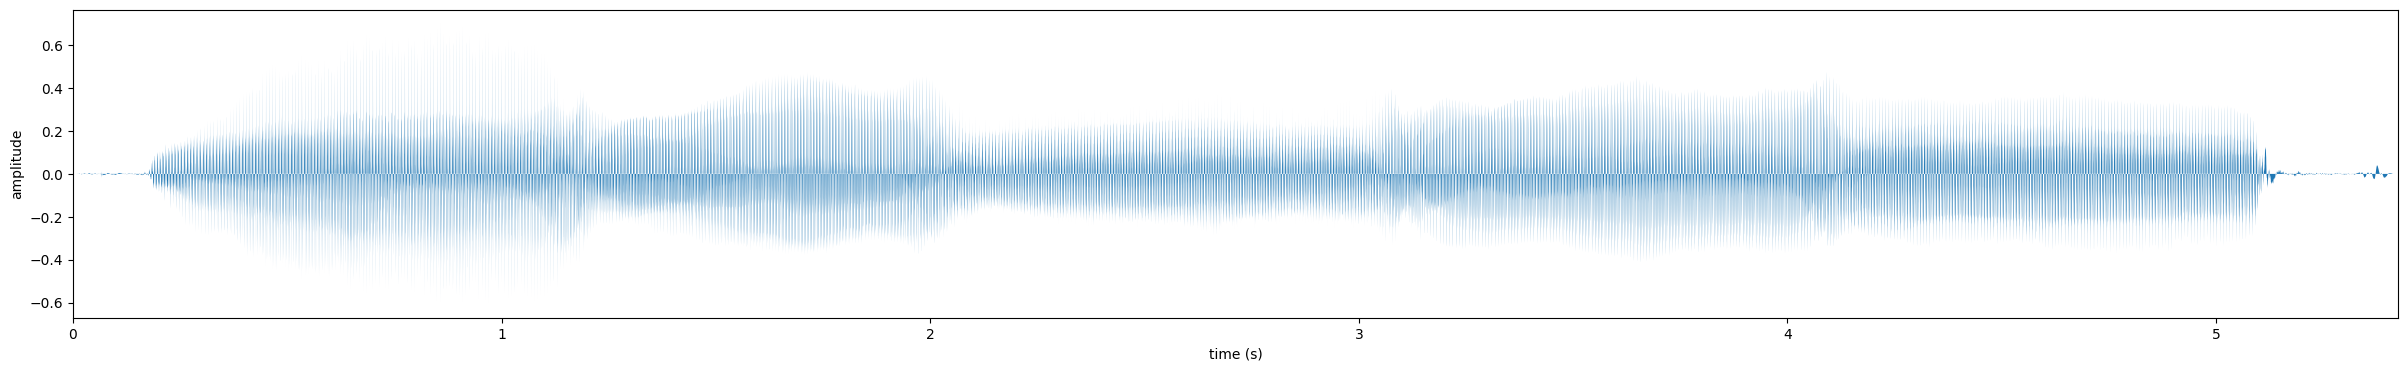

In [74]:
# plotting the synthesised signal
times =  np.arange(len(y))*timestep
plot_sound(y, times)

In [75]:
# Playing the synthesised signal
filename = 'synthesis.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

As we can see (or should we say hear), the synthesised signal perfectly matches the original signal one! This proves the correctness of our method! We can now start modifying the speed and pitch of our sound.

### <ins style = "color : purple">Changing the speed of the signal</ins>

We now want to determine the **synthesis marks** that modify the temporal scale by a factor $\alpha$, i.e., to determine a matrix $B$ such that the duration of the signal synthesized by the $\texttt{Synthesis}$ function is equal to the duration of the original signal $s$ multiplied by $\alpha$.

This operation is performed by the function:  

$$\texttt{function B = ChangeTimeScale(alpha, A, Fs)}$$


This function computes the matrix $B$ from:

- the time-scaling factor $\alpha$,
- the analysis marks stored in matrix $A$,
- and the sampling frequency $F_s$.

We can construct $B$ recursively for $k \geq 1$, by using a **non-integer index** $n(k)$.

The recursive steps for computing the synthesis marks are as follows:

- $t_s(k) = t_s(k - 1) + P_a(\lfloor n(k) \rfloor)$
- $n(k + 1) = n(k) + \frac{1}{\alpha}$



In [76]:
def ChangeTimeScale(alpha, A, Fs = Fs):
    """
        Changing the time scale of the signal
        ------------------------------------------------------
        returns :
            B : synthesis marks that modify the temporal scale by alpha
    """

    # Init the variables
    n = 1
    B = [[0, 0]]
    ts = 0

    while int(n) < A.shape[1] - 1:
        
        # Recursively updating the variables
        ts = ts + A[2, int(round(n))]
        B.append([int(ts), int(n)])
        n += 1 / alpha

    # Transposing and returning the result
    B = np.array(B).T
    return B

To test the correctness of our function, we will try speeding up the $\text{aeiou.wav}$ by a factor of $2$, i.e $\alpha = \frac{1}{2}$.

In [77]:
# Getting the synthesis marks with alpha = 1/2
B_2 = ChangeTimeScale(1/2, A, Fs)

In [78]:
# Building the sped up signal
y_2 = Synthesis(x, Fs, A, B_2)
sf.write('synthesis_2.wav',y_2 ,samplerate=Fs) # writing
# Reading the soundfile
filename = 'synthesis_2.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

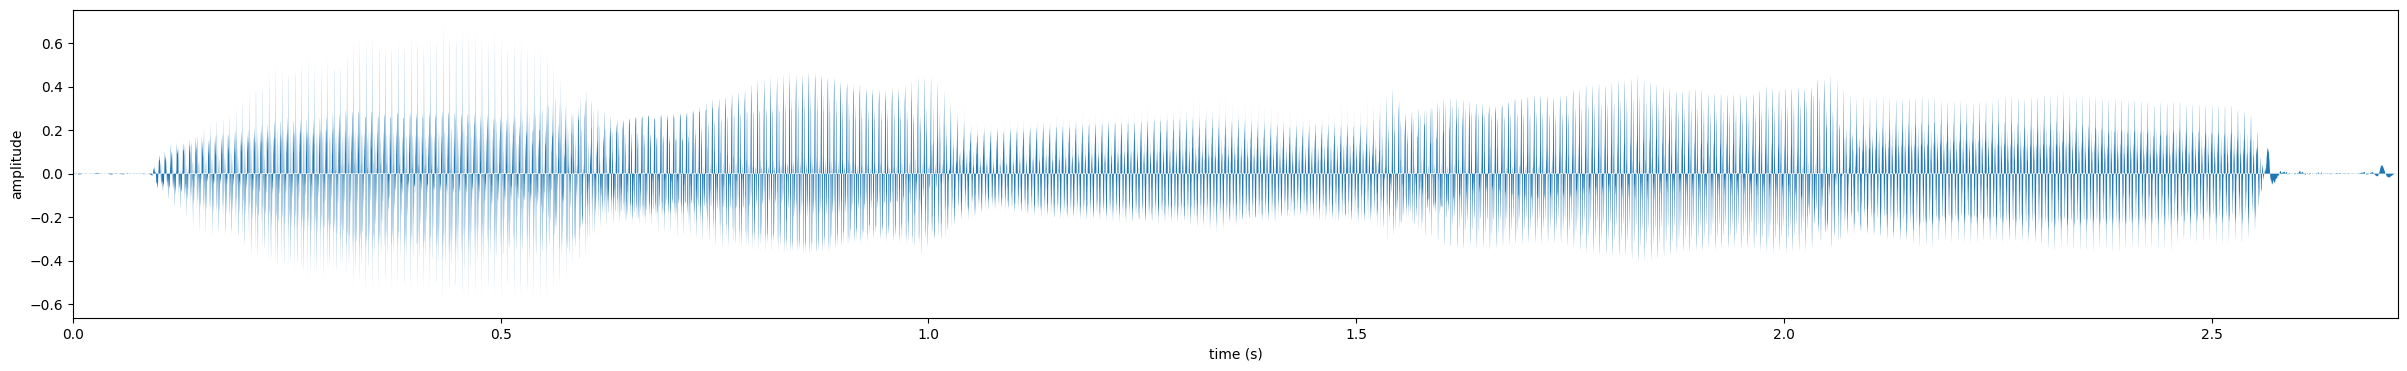

In [79]:
# Plotting the soundfile
times =  np.arange(len(y_2))*timestep
plot_sound(y_2, times)

As we can see, the sound is indeed two times faster ! This proves the correctness of this method too!

### <ins style = "color : red">Changing the Pitch of the signal</ins> 

We will now perform the **dual operation** of time-scaling by determine the **synthesis marks** that modify the **spectral scale** by a factor $\beta$.

The goal here to compute a matrix $B$ such that the **fundamental frequency** of the signal synthesized by the $\texttt{Synthesis}$ function is equal to that of the original signal $s$, **multiplied by $\beta$**.

This operation is performed by the function:

$$\texttt{function B = ChangePitchScale(beta,A,Fs)}$$

This function computes the matrix $B$ from:

- the pitch-scaling factor $\beta$,
- the analysis marks stored in matrix $A$,
- and the sampling frequency $F_s$.

As in the time-scaling case, the synthesis marks are computed recursively for $k \geq 1$, using a **non-integer index** $n(k)$ and **non-integer synthesis times** $t_s(k)$. We must handle **voiced** and **unvoiced** segments differently:

#### Recursive update rules:

- If the analysis mark of index $\lfloor n(k) \rfloor$ is **voiced**, then:
  $$
  \text{scale}(k) = \frac{1}{\beta}
  $$
  Otherwise:
  $$
  \text{scale}(k) = 1
  $$
- Update the synthesis time:
  $$
  t_s(k) = t_s(k - 1) + \text{scale}(k) \cdot P_a(\lfloor n(k) \rfloor)
  $$
- Update the analysis index:
  $$
  n(k + 1) = n(k) + \text{scale}(k)
  $$

As before, only **integer values** are stored in matrix $B$:

- $B(1, k) = \lfloor t_s(k) \rfloor$
- $B(2, k) = \lfloor n(k) \rfloor$



In [80]:
def ChangePitchScale(beta,A,Fs):
    """
        Change the scale of the pitch mark if they are voiced or not by a factor beta
        -----------------------------------------------------------------------------
        return :
            B : modified pitch marks
    """

    # Init B Matrix
    B = [[1, 0]]
    n = 1
    ts = 0

    while int(n) < A.shape[1] - 1:

        # Getting the scale if the sample is voiced of not
        scale = (1/beta) if A[1, int(n)] == 1 else 1
        ts = ts + scale * A[2, int(n)]
        # Updating B Matrix
        B.append([int(ts), int(n)])
        n += scale

    # Transposing B
    B = np.array(B).T
    
    return B

To test the correctness of our function, we will change the pitch of the $\text{aeiou.wav}$ by a factor of $5$, i.e we will get a higher pitch.

In [81]:
# Changing the pitch of the signal
B_3 = ChangePitchScale(2, A, Fs)

In [82]:
# Buiinding the new signal
y_3 = Synthesis(x, Fs, A, B_3)
# Writing into a file
sf.write('synthesis_3.wav',y_3 , samplerate=Fs)
# Loading the audio file
filename = 'synthesis_3.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

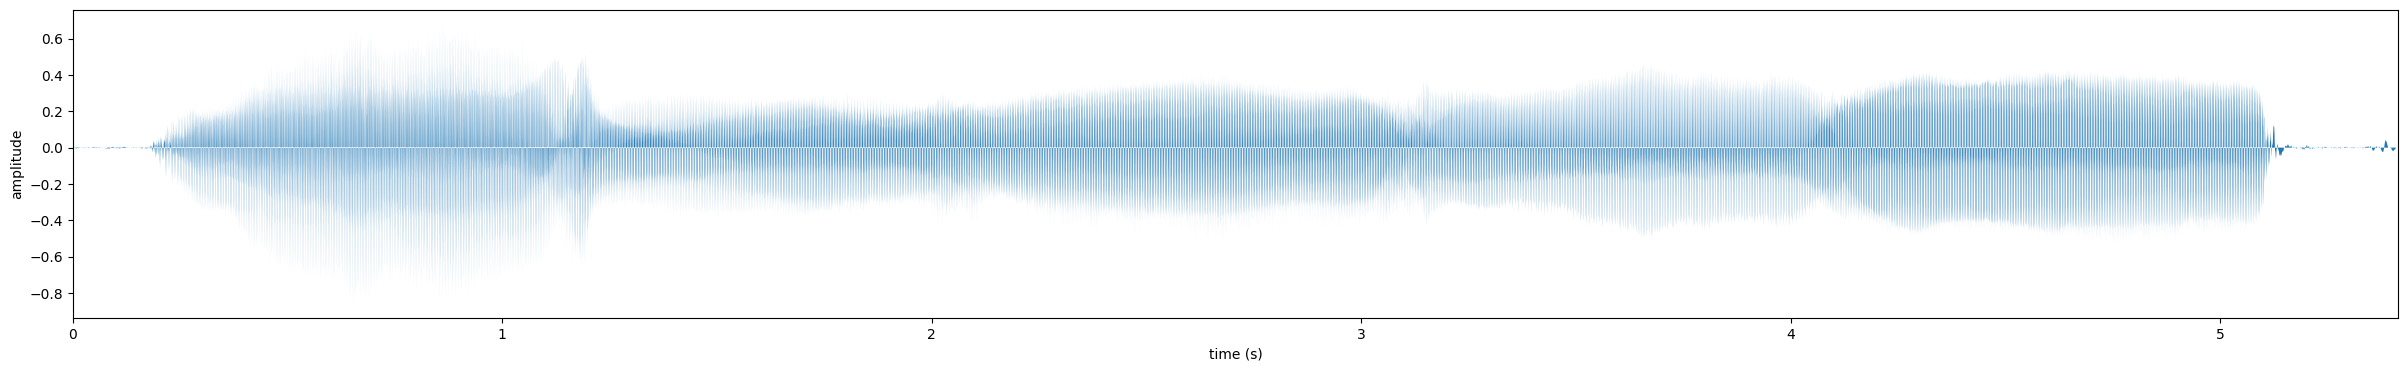

In [83]:
# Plotting the new soundfile 
times =  np.arange(len(y_3))*timestep
plot_sound(y_3, times)

There we go! We can see that the new sound file has a <strong>higher</strong> pitch. We can finally now move onto modifying the speed and pitch of the signal at the same time!

### <ins style = "color : pink">Changing the pitch and speed of the audio file </ins>

To finish, We will program a function that jointly modifies the two scales:

$$\texttt{function B = ChangeBothScales(alpha,beta,A,Fs)}$$

To do so, we will join the two previous algorithms as follow:

#### Recursive update rules:

- If the analysis mark of index $\lfloor n(k) \rfloor$ is **voiced**, then:
  $$
  \text{scale}(k) = \frac{1}{\beta}
  $$
  Otherwise:
  $$
  \text{scale}(k) = 1
  $$
- Update the synthesis time:
  $$
  t_s(k) = t_s(k - 1) + \text{scale}(k) \cdot P_a(\lfloor n(k) \rfloor)
  $$
- Update the analysis index:
  $$
  n(k + 1) = n(k) + \frac{\text{scale}(k)}{\alpha}
  $$

As before, only **integer values** are stored in matrix $B$:

- $B(1, k) = \lfloor t_s(k) \rfloor$
- $B(2, k) = \lfloor n(k) \rfloor$

In [84]:
def ChangeBothScales(alpha, beta, A, Fs):
    """
        Changing the Pitch and the speed of the signal by factors alpha and beta
        ------------------------------------------------------------------------
        returns :
            B : modified pitch marks by the new factor scale/alpha 
    """

    # Init B Matrix
    B = [[0, 0]]  
    ts = 0      
    n = 0      

    while n < A.shape[1] - 1:  
        
        # Change scale if the pitch mark is voiced or not
        scale = (1 / beta) if A[1, int(n)] == 1 else 1
        ts += scale * A[2, int(n)]
        
        B.append([int(ts), int(n)])
        
        # New update of n
        n += scale / alpha

    return np.array(B).T

To test the correctness of our method, we will speed up and change the pitch with the previously used parameters, i.e $\alpha = \frac{1}{2}$ and $\beta = 5$

In [85]:
B_final = ChangeBothScales(1/2, 5, A, Fs)

In [86]:
# Synthesising the final signal, sped up and higher pitch
y_4 = Synthesis(x, Fs, A, B_final)
# writing into a new file
sf.write('synthesis_4.wav',y_4 , samplerate=Fs)
# displaying the audio 
filename = 'synthesis_4.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

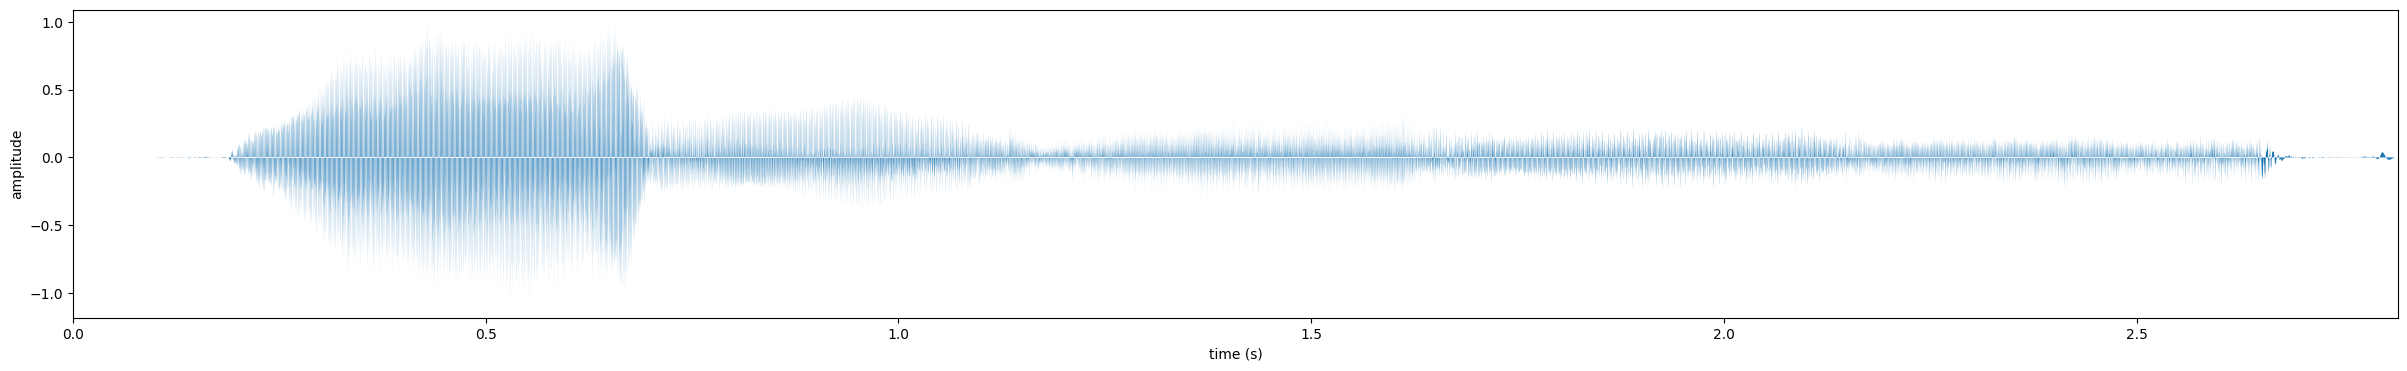

In [87]:
# Plotting the sound
times =  np.arange(len(y_4))*timestep
plot_sound(y_4, times)

Perfect! The new soud is faster and has a higher pitch, proving the correctness of our final implementation!

### <ins style = "color : gold">Conclusion </ins>

In conclusion, we have successfuly implemented the <strong>PSOLA</strong> method, which enables us now to change the pitch and the speed of our audio files as we please!